In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from time import perf_counter

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,17.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
3,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,15.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
4,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,15.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P37136', 'xref_name': None, 'xre...",Rattus norvegicus,Acetylcholinesterase,15.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116
6,"[{'xref_id': 'O42275', 'xref_name': None, 'xre...",Electrophorus electricus,Acetylcholinesterase,15.0,False,CHEMBL4078,"[{'accession': 'O42275', 'component_descriptio...",SINGLE PROTEIN,8005
7,"[{'xref_id': 'P23795', 'xref_name': None, 'xre...",Bos taurus,Acetylcholinesterase,15.0,False,CHEMBL4768,"[{'accession': 'P23795', 'component_descriptio...",SINGLE PROTEIN,9913
8,[],Anopheles gambiae,Acetylcholinesterase,15.0,False,CHEMBL2046266,"[{'accession': 'Q869C3', 'component_descriptio...",SINGLE PROTEIN,7165
9,[],Bemisia tabaci,AChE2,15.0,False,CHEMBL2366409,"[{'accession': 'B3SST5', 'component_descriptio...",SINGLE PROTEIN,7038


In [4]:
# 7m10s
activity = new_client.activity
res = activity.filter(target_chembl_id='CHEMBL220').filter(standard_type="IC50")
df = pd.DataFrame(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,None,20703835,[],CHEMBL4627889,Inhibition of AChE (unknown origin) using acet...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,None,None,CHEMBL4627271,Bioorg Med Chem Lett,2020.0,"{'bei': '14.05', 'le': '0.27', 'lle': '1.62', ...",CHEMBL4645659,None,CHEMBL4645659,6.13,False,http://www.openphacts.org/units/Nanomolar,3486808,=,1,True,=,None,IC50,nM,None,740.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.74
7545,None,20703856,[],CHEMBL4627888,Inhibition of AChE (unknown origin),B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,None,None,CHEMBL4627271,Bioorg Med Chem Lett

In [5]:
# df.set_index(keys=, inplace=True)
df = df[['molecule_chembl_id', 'canonical_smiles','standard_value']]
df.dropna(inplace=True)
df.drop_duplicates(subset='canonical_smiles', inplace=True)
df['standard_value'] = df['standard_value'].astype(np.float64)
df.reset_index(drop=True, inplace=True)
df

/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0
...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0


In [6]:
# label as active or inactive
bioactivity_threshold = []
for i in df.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")
df['class'] = bioactivity_threshold
df

/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1.Cl,266000.0,inactive
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive


In [7]:
# PART 2

In [8]:
df['canonical_smiles'] = df['canonical_smiles'].map(lambda x: max(x.split('.'), key=len))

/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
def lipinski(smiles):

    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData = np.arange(1,1)
    i = 0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i += 1      
    
    columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [10]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
5098,306.406,2.7027,2.0,4.0
5099,436.489,4.5050,1.0,7.0
5100,331.441,3.2431,1.0,5.0
5101,447.506,5.1143,1.0,5.0


In [11]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,266000.0,inactive
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive


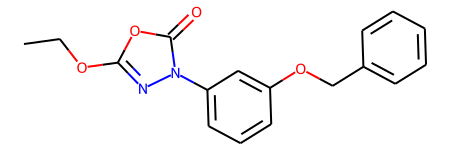

In [12]:
Chem.MolFromSmiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1')

In [16]:
df = pd.concat([df, df_lipinski], axis=1)
df

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,266000.0,inactive,306.406,2.7027,2.0,4.0
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,740.0,active,436.489,4.5050,1.0,7.0
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,510.0,active,331.441,3.2431,1.0,5.0
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,125000.0,inactive,447.506,5.1143,1.0,5.0


In [17]:
def norm_value(data):
    norm = []

    for i in data['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    data['standard_value_norm'] = norm
    x = data.drop(columns='standard_value')
        
    return x

In [18]:
def pIC50(data):
    pIC50 = []

    for i in data['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    data['pIC50'] = pIC50
    x = data.drop(columns='standard_value_norm')
        
    return x

In [19]:
df = norm_value(df)
df = pIC50(df)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


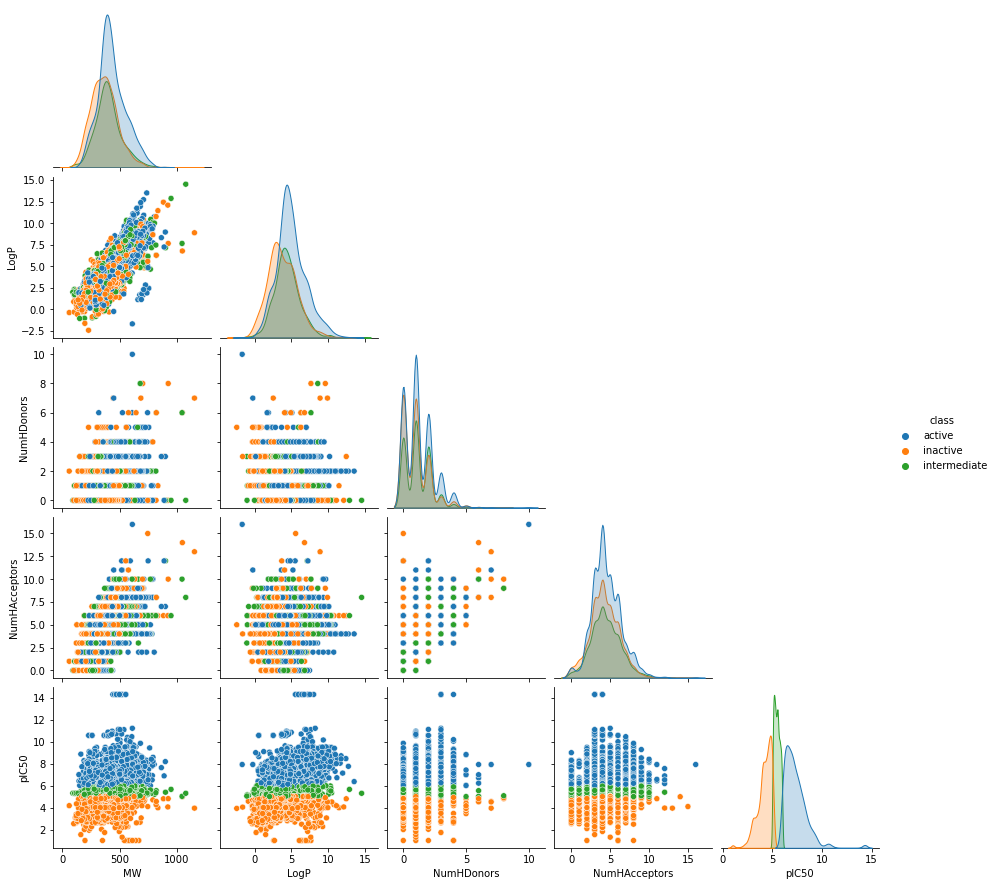

In [21]:
sns.pairplot(data=df, hue='class', corner=True)
plt.show()

In [23]:
df_2class = df[df['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5098,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,inactive,306.406,2.7027,2.0,4.0,3.575118
5099,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,active,436.489,4.5050,1.0,7.0,6.130768
5100,CHEMBL513063,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,active,331.441,3.2431,1.0,5.0,6.292430
5101,CHEMBL4640608,COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1...,inactive,447.506,5.1143,1.0,5.0,3.903090


In [25]:
df['class'].value_counts()

active          2236
inactive        1627
intermediate    1240
Name: class, dtype: int64

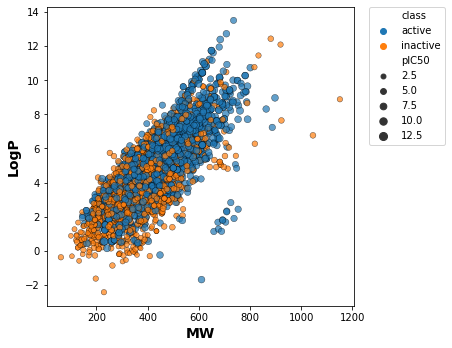

In [28]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [29]:
def mannwhitney(descriptor):
  # from numpy.random import randn
  # from scipy.stats import mannwhitneyu

# seed the random number generator
  np.random.seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = scipy.stats.mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

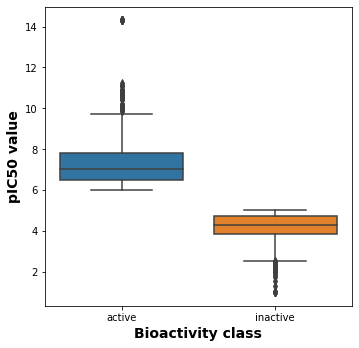

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.show()

In [31]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3637972.0,0.0,0.05,Different distribution (reject H0)


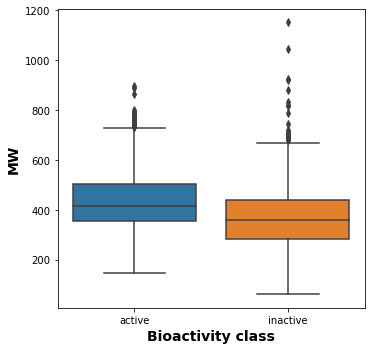

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
plt.show()

In [33]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2377439.0,7.525552e-60,0.05,Different distribution (reject H0)


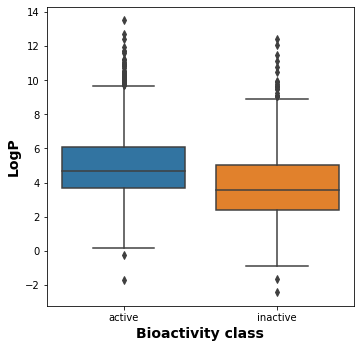

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.show()

In [35]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2427121.5,1.247187e-70,0.05,Different distribution (reject H0)


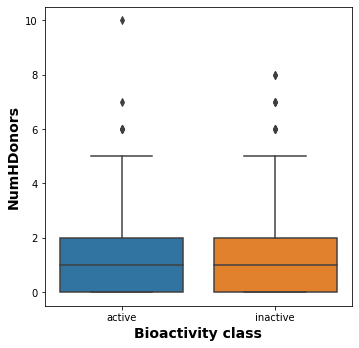

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.show()

In [37]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2068562.0,1.958353e-14,0.05,Different distribution (reject H0)


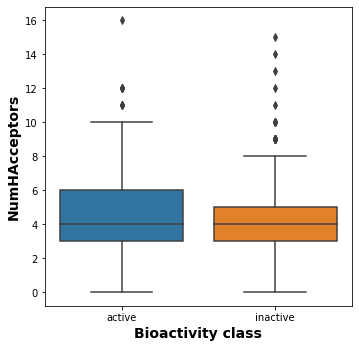

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.show()

In [39]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1935770.5,0.000523,0.05,Different distribution (reject H0)


In [40]:
# PART 3

In [41]:
selection = ['canonical_smiles','molecule_chembl_id']
df[selection].to_csv('molecule.smi', sep='\t', index=False, header=False)

In [42]:
! wget -O padel.sh  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! wget -O padel.zip https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2021-10-31 15:39:52--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2021-10-31 15:39:53--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
SSL_INIT
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh’

padel.sh            100%[===================>]     231  --.-KB/s    in 0s      

2021-10-31 15:39:53 (36.2 MB/s) - ‘padel.sh’ saved [23

In [43]:
! unzip -o padel.zip
! rm -rf padel.zip __MACOSX

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [44]:
! bash padel.sh

Processing CHEMBL336398 in molecule.smi (2/5103). 
Processing CHEMBL133897 in molecule.smi (1/5103). 
Processing CHEMBL131588 in molecule.smi (3/5103). 
Processing CHEMBL130628 in molecule.smi (4/5103). 
Processing CHEMBL130478 in molecule.smi (5/5103). 
Processing CHEMBL130112 in molecule.smi (6/5103). 
Processing CHEMBL130098 in molecule.smi (7/5103). 
Processing CHEMBL337486 in molecule.smi (8/5103). 
Processing CHEMBL336538 in molecule.smi (9/5103). 
Processing CHEMBL131051 in molecule.smi (10/5103). 
Processing CHEMBL341437 in molecule.smi (11/5103). 
Processing CHEMBL335033 in molecule.smi (12/5103). 
Processing CHEMBL338720 in molecule.smi (14/5103). Average speed: 0.83 s/mol.
Processing CHEMBL122983 in molecule.smi (13/5103). Average speed: 1.62 s/mol.
Processing CHEMBL339995 in molecule.smi (15/5103). Average speed: 0.55 s/mol.
Processing CHEMBL131536 in molecule.smi (17/5103). Average speed: 0.34 s/mol.
Processing CHEMBL335158 in molecule.smi (16/5103). Average speed: 0.42 s/

In [47]:
x = pd.read_csv('descriptors_output.csv')
x.drop(columns='Name', inplace=True)
x = x.loc[:, x.var() != 0]
x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP28,PubchemFP30,PubchemFP31,PubchemFP33,PubchemFP34,PubchemFP37,PubchemFP38,PubchemFP39,PubchemFP43,PubchemFP44,PubchemFP46,PubchemFP47,PubchemFP66,PubchemFP115,PubchemFP116,PubchemFP118,PubchemFP129,PubchemFP130,PubchemFP131,PubchemFP132,PubchemFP143,PubchemFP144,PubchemFP145,PubchemFP146,PubchemFP147,PubchemFP148,PubchemFP149,PubchemFP150,PubchemFP151,PubchemFP152,PubchemFP153,PubchemFP154,PubchemFP155,PubchemFP156,PubchemFP157,PubchemFP159,PubchemFP160,PubchemFP164,PubchemFP166,PubchemFP167,PubchemFP171,PubchemFP173,PubchemFP174,PubchemFP178,PubchemFP179,PubchemFP180,PubchemFP181,PubchemFP182,PubchemFP183,PubchemFP184,PubchemFP185,PubchemFP186,PubchemFP187,PubchemFP188,PubchemFP189,PubchemFP190,PubchemFP191,PubchemFP192,PubchemFP193,PubchemFP194,PubchemFP195,PubchemFP197,PubchemFP198,PubchemFP199,PubchemFP200,PubchemFP201,PubchemFP202,PubchemFP206,PubchemFP207,PubchemFP209,PubchemFP213,PubchemFP214,PubchemFP215,PubchemFP216,PubchemFP217,PubchemFP218,PubchemFP219,PubchemFP220,PubchemFP221,PubchemFP222,PubchemFP223,PubchemFP227,PubchemFP228,PubchemFP229,PubchemFP230,PubchemFP241,PubchemFP243,PubchemFP244,PubchemFP248,PubchemFP250,PubchemFP251,PubchemFP255,PubchemFP256,PubchemFP257,PubchemFP258,PubchemFP259,PubchemFP260,PubchemFP261,PubchemFP262,PubchemFP283,PubchemFP284,PubchemFP285,PubchemFP286,PubchemFP287,PubchemFP291,PubchemFP292,PubchemFP293,PubchemFP294,PubchemFP296,PubchemFP297,PubchemFP298,PubchemFP299,PubchemFP300,PubchemFP301,PubchemFP304,PubchemFP305,PubchemFP308,PubchemFP314,PubchemFP316,PubchemFP327,PubchemFP328,PubchemFP329,PubchemFP330,PubchemFP331,PubchemFP332,PubchemFP333,PubchemFP334,PubchemFP335,PubchemFP336,PubchemFP337,PubchemFP338,PubchemFP339,PubchemFP340,PubchemFP341,PubchemFP342,PubchemFP343,PubchemFP344,PubchemFP345,PubchemFP346,PubchemFP347,PubchemFP348,PubchemFP349,PubchemFP350,PubchemFP351,PubchemFP352,PubchemFP353,PubchemFP354,PubchemFP355,PubchemFP356,PubchemFP357,PubchemFP358,PubchemFP359,PubchemFP360,PubchemFP361,PubchemFP362,PubchemFP363,PubchemFP364,PubchemFP365,PubchemFP366,PubchemFP367,PubchemFP368,PubchemFP369,PubchemFP370,PubchemFP371,PubchemFP372,PubchemFP373,PubchemFP374,PubchemFP375,PubchemFP376,PubchemFP377,PubchemFP378,PubchemFP379,PubchemFP380,PubchemFP381,PubchemFP382,PubchemFP383,PubchemFP384,PubchemFP385,PubchemFP386,PubchemFP387,PubchemFP388,PubchemFP389,PubchemFP390,PubchemFP391,PubchemFP392,PubchemFP393,PubchemFP394,PubchemFP395,PubchemFP396,PubchemFP397,PubchemFP398,PubchemFP399,PubchemFP400,PubchemFP401,PubchemFP403,PubchemFP404,PubchemFP405,PubchemFP406,PubchemFP407,PubchemFP409,PubchemFP410,PubchemFP411,PubchemFP412,PubchemFP413,PubchemFP414,PubchemFP415,PubchemFP416,PubchemFP417,PubchemFP418,PubchemFP419,PubchemFP420,PubchemFP421,PubchemFP422,PubchemFP423,PubchemFP425,PubchemFP427,PubchemFP428,PubchemFP429,PubchemFP430,PubchemFP431,PubchemFP432,PubchemFP434,PubchemFP435,PubchemFP436,PubchemFP437,PubchemFP438,PubchemFP439,PubchemFP440,PubchemFP441,PubchemFP442,PubchemFP443,PubchemFP445,PubchemFP446,PubchemFP447,PubchemFP448,PubchemFP449,PubchemFP450,PubchemFP451,PubchemFP452,PubchemFP453,PubchemFP454,PubchemFP455,PubchemFP456,PubchemFP457,PubchemFP458,PubchemFP459,PubchemFP460,PubchemFP461,PubchemFP462,PubchemFP464,PubchemFP465,PubchemFP466,PubchemFP467,PubchemFP470,PubchemFP471,PubchemFP472,PubchemFP473,PubchemFP474,PubchemFP475,PubchemFP476,PubchemFP477,PubchemFP478,PubchemFP479,PubchemFP480,PubchemFP481,PubchemFP482,PubchemFP483,PubchemFP484,PubchemFP485,PubchemFP486,PubchemFP487,PubchemFP488,PubchemFP489,PubchemFP490,PubchemFP491,PubchemFP492,PubchemFP493,PubchemFP494,PubchemFP495,PubchemFP496,PubchemFP497,PubchemFP498,PubchemFP499,PubchemFP500,PubchemFP501,PubchemFP502,PubchemFP503,PubchemFP504,PubchemFP505,PubchemF

In [48]:
y = df['pIC50']
y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5098    3.575118
5099    6.130768
5100    6.292430
5101    3.903090
5102    4.000000
Name: pIC50, Length: 5103, dtype: float64

In [49]:
n_comps = 2
mapper = umap.UMAP(
    n_components = n_comps,
)
mapper.fit(x)
temp = pd.DataFrame(mapper.transform(x), columns=[f'UMAP{i}' for i in range(1, n_comps+1)])

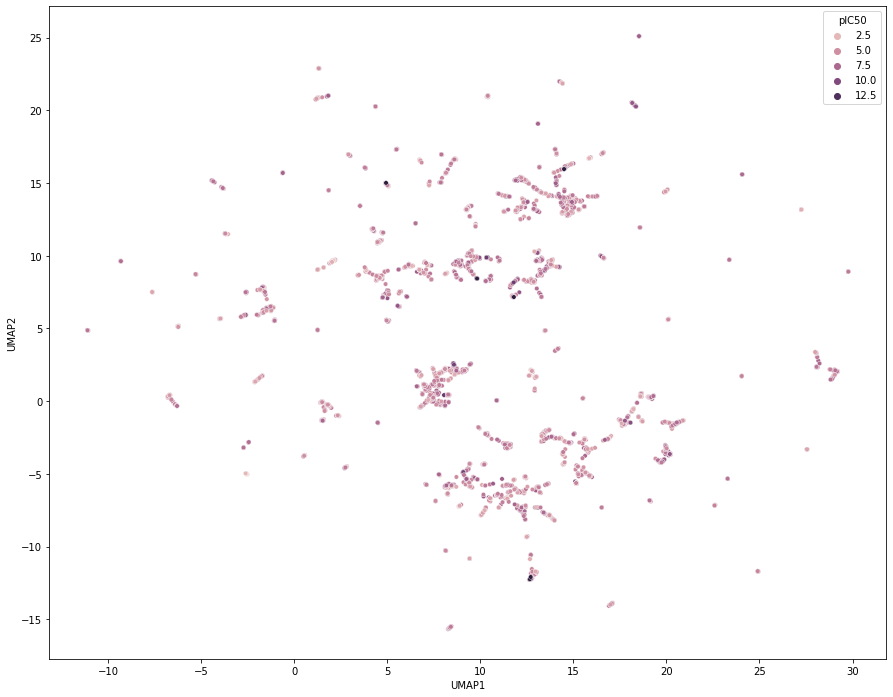

In [50]:
plt.figure(figsize=(15,12))
sns.scatterplot(data=pd.concat([temp, y], axis=1), x='UMAP1', y='UMAP2', hue='pIC50', s=20)
plt.show()

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [52]:
x_train.shape, y_train.shape

((4082, 634), (4082,))

In [53]:
x_test.shape, y_test.shape

((1021, 634), (1021,))

In [54]:
models = {
    'LReg'   : LinearRegression(),
    'DTree'  : DecisionTreeRegressor(),
    'RFrst'  : RandomForestRegressor(),
    'KNN'    : KNeighborsRegressor(),
    'SVM'    : SVR(),
    'LGBM'   : LGBMRegressor(),
    'XGBR'   : XGBRegressor(use_label_encoder=False, eval_metric='logloss'),
    'NN'     : MLPRegressor(hidden_layer_sizes=(100,100,100), max_iter=100_000),
    'Hist'   : HistGradientBoostingRegressor(),
    'CatBst' : CatBoostRegressor(allow_writing_files=False, verbose=False),
}

In [55]:
print(f'Name\tScore\tTime')
for name,model in models.items():
    t0 = perf_counter()
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    t1 = perf_counter()
    print(f'{name}\t{score:.3f}\t{(t1-t0):.2f}s')

Name	Score	Time
LReg	-1188892487948480806912.000	0.10s
DTree	-0.205	0.12s
RFrst	0.292	7.31s
KNN	0.254	0.10s
SVM	0.252	3.06s
LGBM	0.328	0.32s
XGBR	0.265	1.77s
NN	0.037	7.22s
Hist	0.328	2.61s
CatBst	0.321	3.61s


In [56]:
preds = models['Hist'].predict(x_test)

/opt/miniconda3/envs/cdd_intro/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


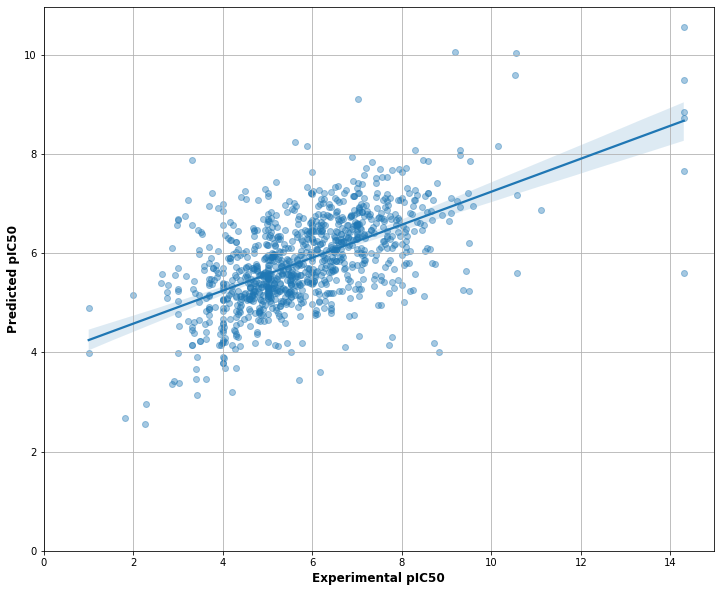

In [57]:
plt.figure(figsize=(12,10))
sns.regplot(y_test, preds, scatter_kws={'alpha':0.4})
plt.xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
plt.ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
plt.xlim(0); plt.ylim(0); plt.grid(); plt.show()